In [214]:
# data = pd.read_csv(r'c:\Github\Sol\the_data\data-lab-3-insurance.csv')
# data.info()

In [215]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
sns.set(style='dark', palette='muted', color_codes=True)
import plotly.express as px 
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

In [216]:
from sklearn.impute import SimpleImputer 
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder,MinMaxScaler,StandardScaler,LabelEncoder
from sklearn.compose import ColumnTransformer 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, silhouette_score, accuracy_score, confusion_matrix, mean_squared_error 
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

In [217]:
data = pd.read_csv(r'c:\Github\Sol\the_data\data-lab-4-heart.csv')
data.head(3)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1


In [218]:
data.duplicated().sum()
data.drop_duplicates(keep='first', subset=None, ignore_index=False,inplace=True)
data.duplicated().sum()

0

In [219]:
mis_val = data.isna().sum() * 100 / len(data)
mis_val.sort_values(ascending=False)

age         0.0
sex         0.0
cp          0.0
trestbps    0.0
chol        0.0
fbs         0.0
restecg     0.0
thalach     0.0
exang       0.0
oldpeak     0.0
slope       0.0
ca          0.0
thal        0.0
target      0.0
dtype: float64

In [220]:
y = data.target 
x = data.drop(columns=['target'])

In [221]:
num_val = ['age','trestbps','chol','thalach','oldpeak' ]
cat_val = ['sex', 'cp', 'restecg', 'exang', 'slope', 'ca', 'thal']

In [222]:
col_transf = ColumnTransformer( 
    [ 
        ('num', StandardScaler(), num_val),
        ('cat', OrdinalEncoder(), cat_val)
    ]
)

x = pd.DataFrame(col_transf.fit_transform(x))
x

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.949794,0.764066,-0.261285,0.018826,1.084022,1.0,3.0,0.0,0.0,0.0,0.0,1.0
1,-1.928548,-0.091401,0.067741,1.636979,2.118926,1.0,2.0,1.0,0.0,0.0,0.0,2.0
2,-1.485726,-0.091401,-0.822564,0.980971,0.307844,0.0,1.0,0.0,0.0,2.0,0.0,2.0
3,0.174856,-0.661712,-0.203222,1.243374,-0.209608,1.0,1.0,1.0,0.0,2.0,0.0,2.0
4,0.285561,-0.661712,2.080602,0.587366,-0.382092,0.0,0.0,1.0,1.0,2.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
297,0.285561,0.478910,-0.106449,-1.161988,-0.727060,0.0,0.0,1.0,1.0,1.0,0.0,3.0
298,-1.042904,-1.232023,0.338703,-0.768384,0.135360,1.0,3.0,1.0,0.0,1.0,0.0,3.0
299,1.503322,0.707035,-1.035462,-0.374779,2.032684,1.0,0.0,1.0,0.0,1.0,2.0,3.0
300,0.285561,-0.091401,-2.235438,-1.511859,0.135360,1.0,0.0,1.0,1.0,1.0,1.0,3.0


In [223]:
x_train,x_test,y_train,y_test = train_test_split(x,y, random_state=42, test_size=0.2)

In [224]:
logreg = LogisticRegression()

logreg.fit(x_train,y_train)

y_true = y_test
y_pred = logreg.predict(x_test)

In [225]:
acc_scr = accuracy_score(y_true,y_pred).round(3)

modperf = pd.DataFrame( [
    'LogisticRegression', acc_scr ]
).transpose()

modperf.columns = ['Method', 'Test Accuracy']

modperf

,Method,Test Accuracy
0,LogisticRegression,0.836


<AxesSubplot:xlabel='Predicted Values', ylabel='True Values'>

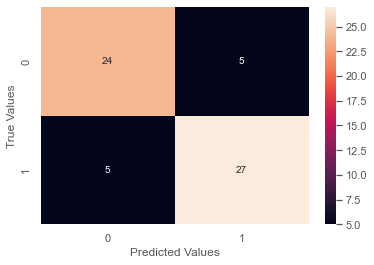

In [226]:
conf_dict = { 
    'y_true':y_true,
    'y_pred':y_pred
}

conf_colms = pd.DataFrame( 
    conf_dict, columns=['y_true', 'y_pred']
)

confusion_matrix = pd.crosstab( 
    conf_colms['y_true'], conf_colms['y_pred'], rownames=['True Values'], colnames=['Predicted Values']
)

sns.heatmap(confusion_matrix, annot=True)